In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read in Configuration And Adjust Where Files are Stored
First we will look the default configuration

Then we adjust the `ssj_cdf_root_dir` parameter (which determines where the code searches for 'raw' data it needs)

In [4]:
from ssjlatbin.io import read_config
config = read_config('../scripts/default_config.toml')

In [5]:
#Show the configurable parameters
import pprint
pprint.pprint(config)

{'all_channels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 'calculation': {'uncertainty_tolerance': 100},
 'dataframevar_to_cdfvar': {'glats': 'SC_GEOCENTRIC_LAT',
                            'glons': 'SC_GEOCENTRIC_LON',
                            'mlats': 'SC_AACGM_LAT',
                            'mlts': 'SC_AACGM_LTIME'},
 'hard_channels': [0, 1, 2, 3, 4, 5, 6, 7, 8],
 'io': {'parquet_root_dir': '/home/ec2-user/SageMaker/efs/data/ssj_latbin/parquet',
        'ssj_cdf_root_dir': '/home/ec2-user/SageMaker/efs/data/dmspssjdata/',
        'ssj_cdf_version': '1.1.4'},
 'latbin': {'delta_lat': 2, 'max_lat': 80},
 'soft_channels': [10, 11, 12, 13, 14, 15, 16, 17]}


In [6]:
#Make changes to the configuration so that data is stored with this notebook, and the correct version of the data is used
import os
config['io']['ssj_cdf_root_dir']='../dat'
config['io']['ssj_cdf_version']='1.1.5'
if not os.path.exists(config['io']['ssj_cdf_root_dir']):
    os.makedirs(config['io']['ssj_cdf_root_dir'])

# Download a few days of DMSP SSJ data from NASA

In [138]:
#Here we set the satellite we are going to use and the range of time we will examine
import datetime
dmsp_number = 13
sdt = datetime.datetime(2006,11,20)
edt = datetime.datetime(2006,12,20)

In [139]:
#This code downloaded the data from NASA Space Physics Data Facility servers
import requests
base_url = 'https://cdaweb.gsfc.nasa.gov/pub/data/dmsp/dmspf13/ssj/precipitating-electrons-ions'
def download_f13_cdf(dt):
    fn = f'dmsp-f13_ssj_precipitating-electrons-ions_{dt.year}{dt.month:02d}{dt.day:02d}_v1.1.5.cdf'
    url = base_url
    url += f'/{dt.year}/'
    url += fn
    response = requests.get(url)
    if response.status_code == 404:
        raise RuntimeError(f'URL {url} returned 404 page not found')
    else:
        localfn = os.path.join(config['io']['ssj_cdf_root_dir'],fn)
        with open(localfn,'wb') as f:
            f.write(response.content)
        print(f'Downloaded \n {url} \n to \n {localfn}')

dt = sdt
while dt <= edt:
    download_f13_cdf(dt)
    dt+=datetime.timedelta(days=1)

Downloaded 
 https://cdaweb.gsfc.nasa.gov/pub/data/dmsp/dmspf13/ssj/precipitating-electrons-ions/2006/dmsp-f13_ssj_precipitating-electrons-ions_20061120_v1.1.5.cdf 
 to 
 ../dat/dmsp-f13_ssj_precipitating-electrons-ions_20061120_v1.1.5.cdf
Downloaded 
 https://cdaweb.gsfc.nasa.gov/pub/data/dmsp/dmspf13/ssj/precipitating-electrons-ions/2006/dmsp-f13_ssj_precipitating-electrons-ions_20061121_v1.1.5.cdf 
 to 
 ../dat/dmsp-f13_ssj_precipitating-electrons-ions_20061121_v1.1.5.cdf
Downloaded 
 https://cdaweb.gsfc.nasa.gov/pub/data/dmsp/dmspf13/ssj/precipitating-electrons-ions/2006/dmsp-f13_ssj_precipitating-electrons-ions_20061122_v1.1.5.cdf 
 to 
 ../dat/dmsp-f13_ssj_precipitating-electrons-ions_20061122_v1.1.5.cdf
Downloaded 
 https://cdaweb.gsfc.nasa.gov/pub/data/dmsp/dmspf13/ssj/precipitating-electrons-ions/2006/dmsp-f13_ssj_precipitating-electrons-ions_20061123_v1.1.5.cdf 
 to 
 ../dat/dmsp-f13_ssj_precipitating-electrons-ions_20061123_v1.1.5.cdf
Downloaded 
 https://cdaweb.gsfc.nasa.go

# Now we load the SSJ raw data into a Pandas DataFrame

First we will set a few more configuration options here:
* `delta_lat` sets the width of the bins (in degrees) into which each orbit is divided
* `uncertainty_tolerance` has to do with filtering out observations which have large uncertainty in flux. Specifically, the code requires $\Phi > \frac{tol}{100}*\sigma_{\Phi}$ where $\Phi$ is flux, $tol$ is `uncertainty_tolerance` and $\sigma_{\Phi}$ is the flux uncertainty.

The `get_orbit_numbered_ssj_range_dataframe` method loads the *raw* particle precipitation observations (1 observation per second) into a Pandas dataframe.


In [140]:
from ssjlatbin.cdf import get_orbit_numbered_ssj_range_dataframe
config['calculation']['uncertainty_tolerance']=75
df = get_orbit_numbered_ssj_range_dataframe(dmsp_number,sdt,edt,config)

File not found for date 2006-11-19 00:00:00


In [141]:
df.head(2)

,glats,glons,mlats,mlts,ele_soft_energy,ele_soft_number,ele_hard_energy,ele_hard_number,ele_total_energy,ele_total_number,...,ion_soft_number,ion_hard_energy,ion_hard_number,ion_total_energy,ion_total_number,time,solar_zenith_angle,orbit_number,orbit_start_time,dglats
2006-11-20 00:25:05,-0.041263,91.893353,-21.922579,6.523930,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2006-11-20 00:25:05,78.885922,0.0,2006-11-20 00:25:05,-0.058176
2006-11-20 00:25:06,-0.099439,91.880185,-21.947078,6.523165,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2006-11-20 00:25:06,78.874499,0.0,2006-11-20 00:25:05,-0.058176


This time-series dataframe contains:

* Spacecraft location in geographic and geomagnetic coordinates
* Electron and ion fluxes for 2 different energy bands (soft and hard)
> ⚠️ Note that flux comes in two varieties: `energy` and `number`:
> * `energy` is the total amount of energy carried by the particles
> * `number` means the total number of particles
* The orbit number 
> * 1 means first complete orbit
> * orbit start is defined as the first measurement after the spacecraft crosses the equator traveling north
* The solar zenith angle
> * sza > 90 means spacecraft was mostly in darkness
> * sza < 90 means spacecraft was mostly in sunlight




# Next, calculate the average flux for each 3 degrees of latitude along every orbit
This is an important step in making the data machine-learning ready because it transforms the data from a 'tall' format (in which each 1-second observation is one row) into a 'wide' format (in which each orbit occupies one row and each latitude bin is one column). 

Additionally, each orbit always has the same number of latitude bins, meaning the 'wide' format data is conveniently divided into samples (rows) and features (columns), and each column represents the same range of latitudes.

The `bin_by_latitude` method handles this transformation.
> ⚠️ Since we are interested in space weather, which organizes relative the earth's magnetic field, we will use magnetic latitude to determine our bins (`latvar='mlats'`)


In [142]:
from ssjlatbin.latbin_pandas import bin_by_latitude
config['latbin']['delta_lat']=3

In [143]:
lbdf = bin_by_latitude(df,config,latvar='mlats')

In [144]:
lbdf

glats  glons  mlats  mlts  ele_soft_energy  \
orbit_start_time    latbin                                                   
2006-11-20 00:25:05 dawn_1.5      NaN    NaN    NaN   NaN              NaN   
                    dawn_4.5      NaN    NaN    NaN   NaN              NaN   
                    dawn_7.5      NaN    NaN    NaN   NaN              NaN   
                    dawn_10.5     NaN    NaN    NaN   NaN              NaN   
                    dawn_13.5     NaN    NaN    NaN   NaN              NaN   
...                               ...    ...    ...   ...              ...   
2006-12-19 20:36:35 dawn_-12.5    NaN    NaN    NaN   NaN              NaN   
                    dawn_-9.5     NaN    NaN    NaN   NaN              NaN   
                    dawn_-6.5     NaN    NaN    NaN   NaN              NaN   
                    dawn_-3.5     NaN    NaN    NaN   NaN              NaN   
                    dawn_-0.5     NaN    NaN    NaN   NaN              NaN   

                                ele_soft_number  ele_hard_energy  \
orbit_start_time    latbin                                         
2006-11-20 00:25:05 dawn_1.5                NaN              NaN   
                    dawn_4.5                NaN              NaN   
                    dawn_7.5                NaN              NaN   
                    dawn_10.5               NaN              NaN   
                    dawn_13.5               NaN              NaN   
...                                         ...              ...   
2006-12-19 20:36:35 dawn_-12.5              NaN              NaN   
                    dawn_-9.5               NaN              NaN   
                    dawn_-6.5               NaN              NaN   
                    dawn_-3.5               NaN              NaN   
                    dawn_-0.5               NaN              NaN   

                                ele_hard_number  ele_total_energy  \
orbit_start_time    latbin                                          
2006-11-20 00:25:05 dawn_1.5                NaN               NaN   
                    dawn_4.5                NaN               NaN   
                    dawn_7.5                NaN               NaN   
                    dawn_10.5               NaN               NaN   
                    dawn_13.5               NaN               NaN   
...                                         ...               ...   
2006-12-19 20:36:35 dawn_-12.5              NaN               NaN   
                    dawn_-9.5               NaN               NaN   
                    dawn_-6.5               NaN               NaN   
                    dawn_-3.5               NaN               NaN   
                    dawn_-0.5               NaN               NaN   

                                ele_total_number  ion_soft_energy  \
orbit_start_time    latbin                                          
2006-11-20 00:25:05 dawn_1.5                 NaN              NaN   
                    dawn_4.5                 NaN              NaN   
                    dawn_7.5                 NaN              NaN   
                    dawn_10.5                NaN              NaN   
                    dawn_13.5                NaN              NaN   
...                                          ...              ...   
2006-12-19 20:36:35 dawn_-12.5               NaN              NaN   
                    dawn_-9.5                NaN              NaN   
                    dawn_-6.5                NaN              NaN   
                    dawn_-3.5                NaN              NaN   
                    dawn_-0.5                NaN              NaN   

                                ion_soft_number  ion_hard_energy  \
orbit_start_time    latbin                                         
2006-11-20 00:25:05 dawn_1.5                NaN              NaN   
                    dawn_4.5                NaN              NaN   
                    dawn_7.5                NaN              NaN

The `lbdf` dataframe has a [Multiindex](https://pandas.pydata.org/pandas-docs/stable/user_guide/cookbook.html#cookbook-multi-index) which is not very intuitive, but is efficient (and useful for storing the data to a Parquet file). The index combines the orbit (which would be a row/sample in the description above) and the latitude bin (the column/feature in the description above). 

The code below shows how to get extract the data for one orbit and shows an example plot which should help explain the way the dataframe is indexed.


               glats       glons      mlats       mlts  ele_soft_energy  \
latbin                                                                    
dawn_4.5    8.175765  337.262428   5.135281  18.653900         0.000138   
dawn_19.5  11.820442  336.418236  20.371372  18.672762         0.000148   
dawn_22.5  18.116740  334.920996  22.309225  18.703243         0.000243   

           ele_soft_number  ele_hard_energy  ele_hard_number  \
latbin                                                         
dawn_4.5      1.541432e+10              0.0              0.0   
dawn_19.5     1.462145e+10              0.0              0.0   
dawn_22.5     2.780135e+10              0.0              0.0   

           ele_total_energy  ele_total_number  ion_soft_energy  \
latbin                                                           
dawn_4.5           0.000138      1.541432e+10              0.0   
dawn_19.5          0.000148      1.462145e+10              0.0   
dawn_22.5          0.000243      2.7801

<AxesSubplot:xlabel='latbin'>

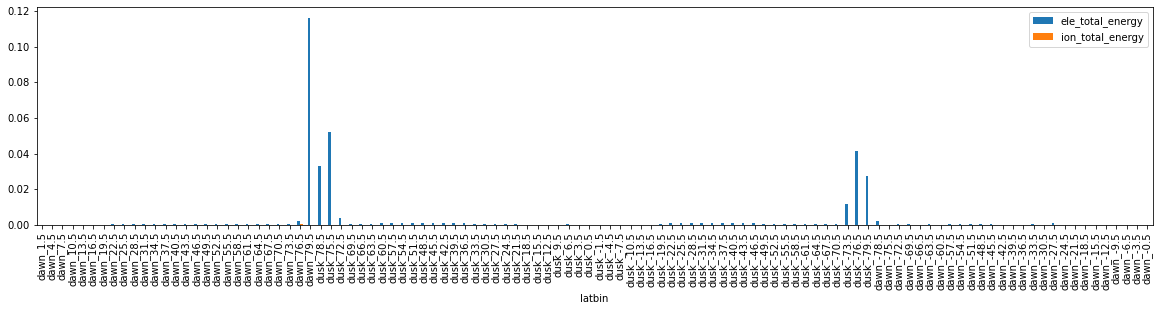

In [145]:
orbit_times = lbdf.index.get_level_values(0).unique()
latitude_bins = lbdf.index.get_level_values(1).unique()
#Get the 11th orbit
orbit_eleven_lbdf = lbdf.loc[orbit_times[11]]
print(orbit_eleven_lbdf.dropna().head(3))
orbit_eleven_lbdf.plot(y=['ele_total_energy','ion_total_energy'],kind='bar',figsize=(20,4))

This plot shows one orbit of data. The two regions of significant electron and ion flux correspond to the spacecraft crossing the auroral oval in the poles of first the northern (left) and then the southern (right) hemisphere. Note that `dusk_` and `dawn_` switch close to $90^o$ latitude.

# Storing the data in a ML-compatible format

We use [Apache Parquet](https://parquet.apache.org/) to store this data. Writing and reading the data from Parquet files is simple and efficient because Pandas supports this format natively.

In [146]:
#Note that depending on pandas/pyarrow version these keyword arguments may need adjusting
lbdf.to_parquet(path='test.parquet',allow_truncated_timestamps=True, coerce_timestamps='us')

# Extracting the data for Visualization or ML
The `dataframe_to_latbinned_flux` method reduces the complicated MultiIndex Pandas DataFrame structure to simpler 2D numpy arrays for a particular type of flux:
* `t` - 1D numpy array shape=(n_orbits,) of datetimes, the time associated with each orbit
* `lats` - 1D numpy array shape=(n_lat_bins,), the center latitude of each bin
* `flag` - 1D numpy array shape=(n_lat_bins,), -1 if the bin was on the dusk side of the orbit, 1 if the bin was on the dawn side of the orbit 
* `fluxes` - 2D numpy array shape=(n_orbits,n_lat_bins), the average flux in each latitude bin for the specified type of flux

This can be useful both for exploratory data analysis (such as plotting), or when organizing the data into a feature matrix for ML

In [147]:
from ssjlatbin.io import dataframe_to_latbinned_flux

In [148]:
t,lats,flag,efluxes = dataframe_to_latbinned_flux(lbdf,'ele_hard_energy')

# Example Plots, Data Cleaning, And Very Basic ML

The following example shows a very simplified version of how this data was used in practice.

The top plot shows the values of one type of flux for each latitude bin for the northern hemisphere dawn side high latitude region (latitude > 40).

In the middle plot, a 3x3 median filter has been applied to the data to remove noise

Finally, the median filtered data is used to train a IsolationForest anomaly detection model (using the first half of the time interval shown as training data, and the second half as testing data). Of course this is a much simpler and smaller input dataset than would be used for actual application, and is shown to demonstrate how the data might be used. 

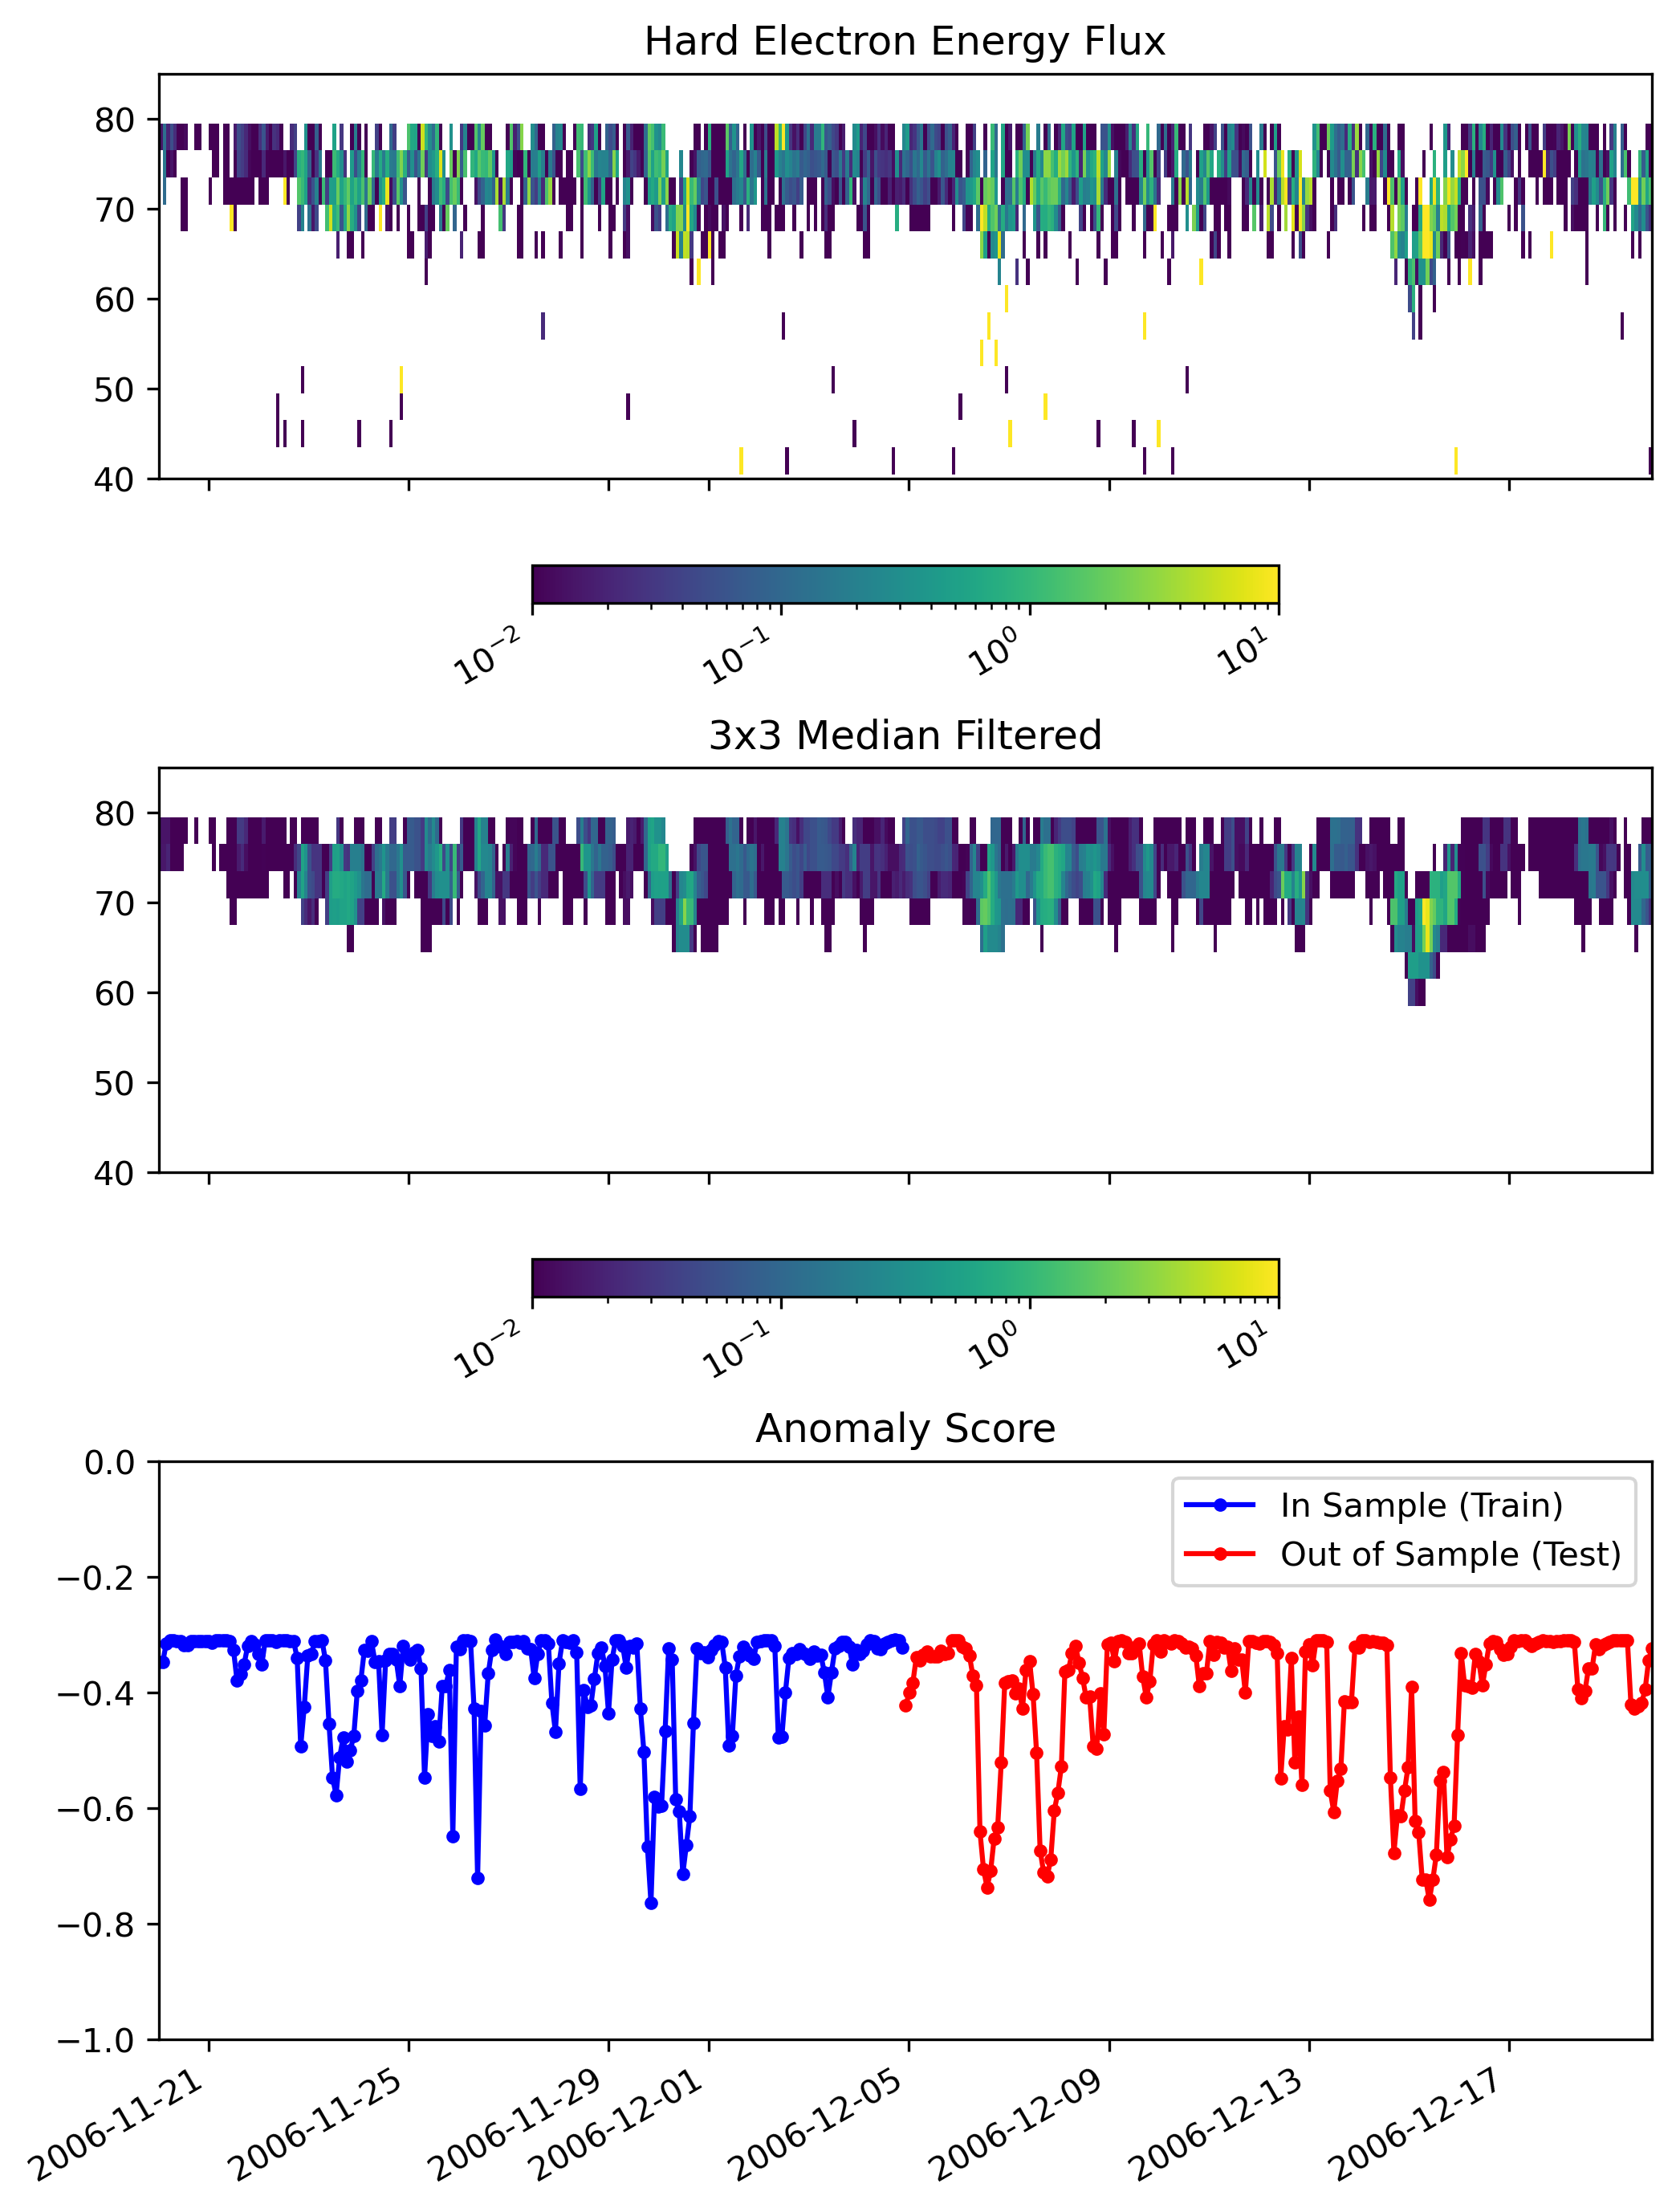

In [152]:
from sklearn.ensemble import IsolationForest
from scipy.ndimage import median_filter

efluxes[np.logical_not(np.isfinite(efluxes))]=0.

mask = np.logical_and(lats>40,flag == 1) #We consider only northern hemisphere high latitude (>40) dawnside

f = plt.figure(figsize=(8,12),dpi=300)
axt = f.add_subplot(311)
axm = f.add_subplot(312)
axb = f.add_subplot(313)

ndawn_lats = lats[mask]
ndawn_flux = efluxes[:,mask] 

mappable = axt.pcolormesh(t,ndawn_lats,ndawn_flux.T,cmap='viridis',vmin=.01,vmax=10,norm=LogNorm())
axt.set_title('Hard Electron Energy Flux')
f.colorbar(mappable,ax=axt,orientation='horizontal',shrink=.5)
axt.set_ylim([40,85])

mappable = axm.pcolormesh(t,ndawn_lats,median_filter(ndawn_flux.T,3),cmap='viridis',vmin=.01,vmax=10,norm=LogNorm())
f.colorbar(mappable,ax=axm,orientation='horizontal',shrink=.5)
axm.set_title('3x3 Median Filtered')
axm.set_ylim([40,85])

#A very basic anomaly detection algorithm
X = median_filter(ndawn_flux,3)
clf = IsolationForest().fit(X[:len(t)//2,:])
in_score = clf.score_samples(X[:len(t)//2,:])
out_score = clf.score_samples(X[len(t)//2:,:])
axb.plot(t[:len(t)//2],in_score,'b.-',label='In Sample (Train)')
axb.plot(t[len(t)//2:],out_score,'r.-',label='Out of Sample (Test)')
axb.set_ylim([-1,0])
axb.legend()
axb.set_title('Anomaly Score')
for ax in [axt,axm,axb]:
    ax.set_xlim(t[0],t[-1])
f.autofmt_xdate()

# Most General Possible Plots

These plots show several import types of flux for both hemispheres and both dawn and dusk sides of the orbit. Solar zenith angle is also plotted to help you understand what is dawn and what is dusk (larger SZA means dusk side).

In [ ]:
from ssjlatbin.fluxcalculations import average_particle_energy
t,lats,_,influxs = dataframe_to_latbinned_flux(lbdf,'ion_soft_number')
t,lats,_,eefluxh = dataframe_to_latbinned_flux(lbdf,'ele_hard_energy')
t,lats,_,eeflux = dataframe_to_latbinned_flux(lbdf,'ele_total_energy')
t,lats,_,enflux = dataframe_to_latbinned_flux(lbdf,'ele_total_number')
t,lats,_,sza = dataframe_to_latbinned_flux(lbdf,'solar_zenith_angle')

eavg = average_particle_energy(eeflux,enflux)
eavg[enflux==0]=0 #Prevent NaN values if zero number flux

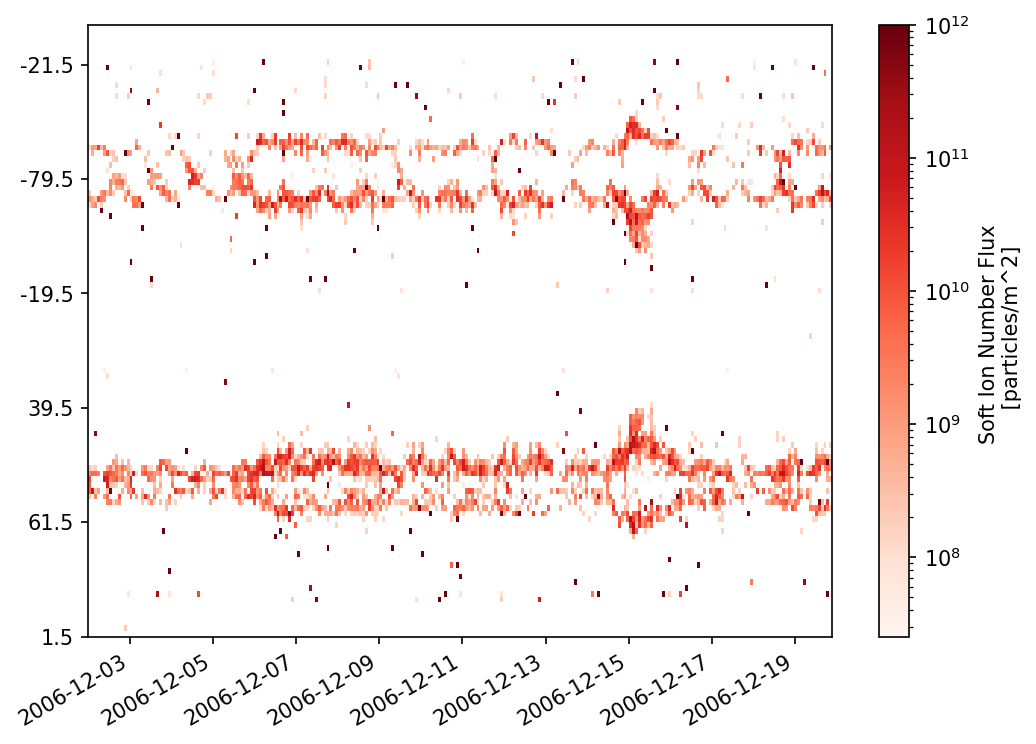

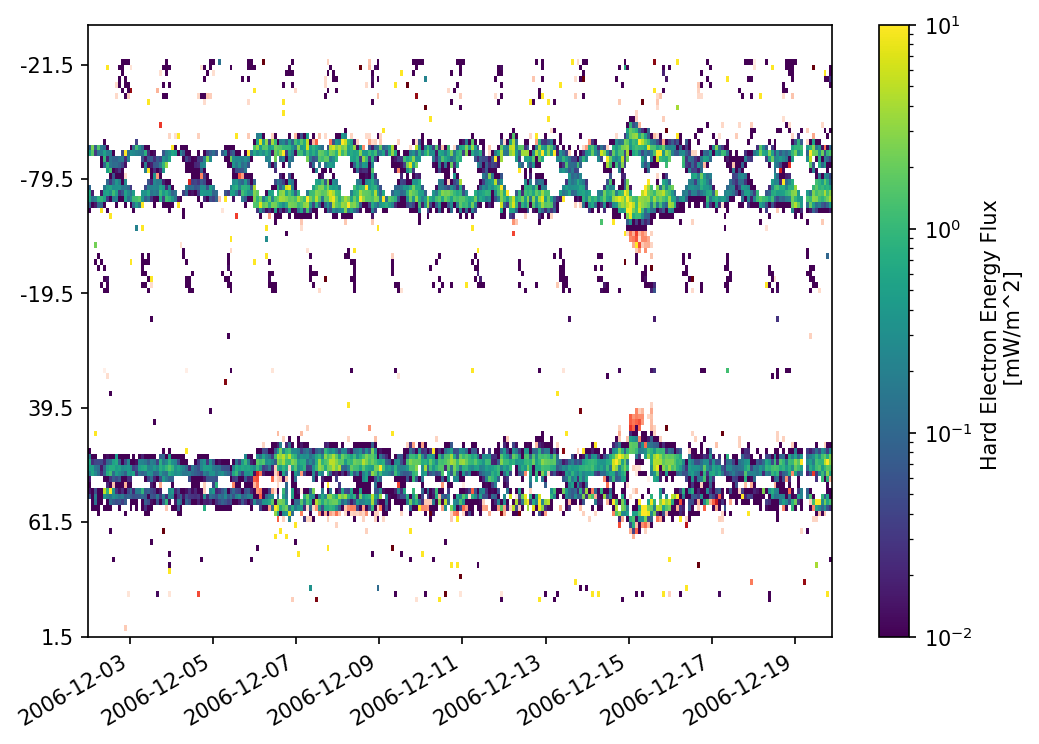

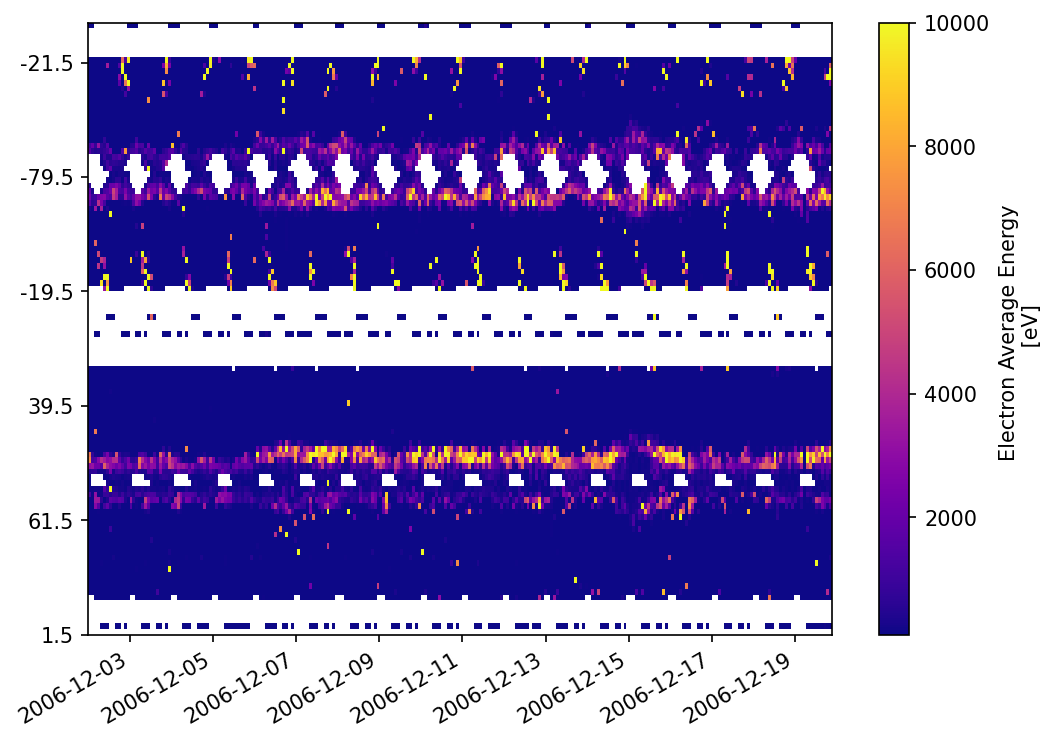

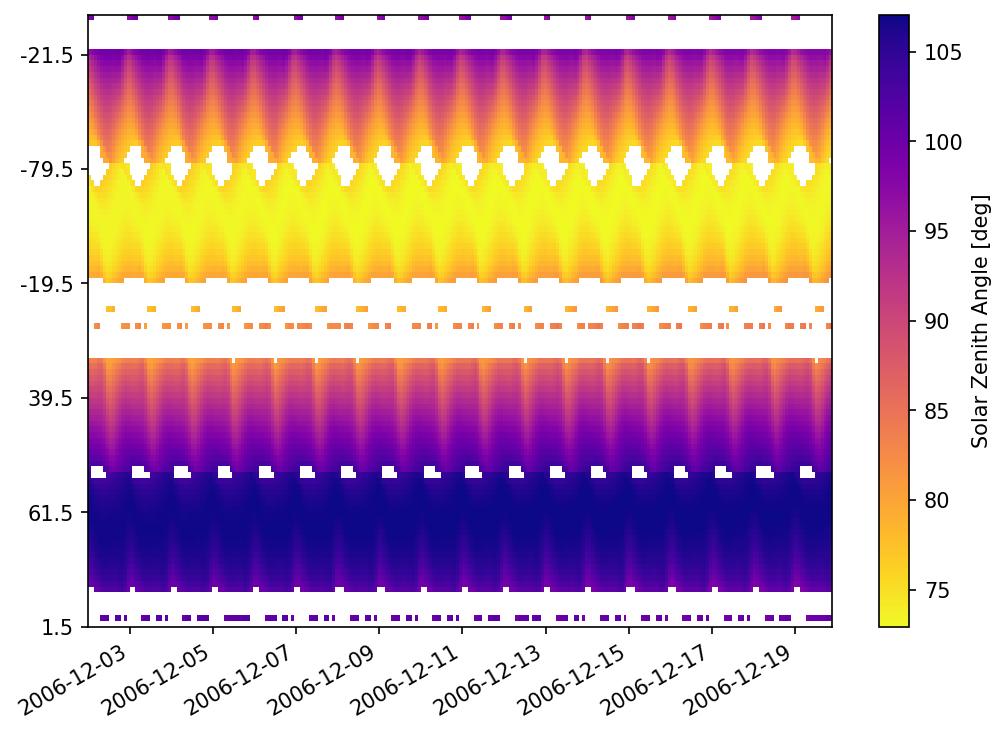

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# import warnings
# warnings.filterwarnings('ignore')

def latlabel(value,tick_number):
    ilat = int(np.round(value))
    if ilat>=len(lats):
        ilat=len(lats)-1
    return '{}'.format(lats[ilat])

N = lats > 0

f = plt.figure(figsize=(8,6),dpi=150)
ax = f.add_subplot(111)
mappable = ax.pcolormesh(t,np.arange(lats.size),influxs.T,vmax=1e12,norm=LogNorm(),cmap='Reds')
ax.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f.colorbar(mappable,label='Soft Ion Number Flux \n [particles/m^2]')
f.autofmt_xdate()

# f = plt.figure(figsize=(8,6),dpi=150)
# ax = f.add_subplot(111)
# mappable = ax.pcolormesh(t,np.arange(lats.size),enflux.T,vmax=1e13,norm=LogNorm())
# ax.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
# f.colorbar(mappable,label='Total Electron Number Flux \n [particles/m^2]')
# f.autofmt_xdate()

# f = plt.figure(figsize=(8,6),dpi=150)
# ax = f.add_subplot(111)
# mappable = ax.pcolormesh(t,np.arange(lats.size),eeflux.T,vmin=.0001,vmax=10,norm=LogNorm())
# ax.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
# f.colorbar(mappable,label='Total Electron Energy Flux \n [mW/m^2]')
# f.autofmt_xdate()

f3 = plt.figure(figsize=(8,6),dpi=150)
ax3 = f3.add_subplot(111)
mappable2 = ax3.pcolormesh(t,np.arange(lats.size),influxs.T,vmax=1e12,norm=LogNorm(),cmap='Reds')
mappable = ax3.pcolormesh(t,np.arange(lats.size),eefluxh.T,vmin=.01,vmax=10,norm=LogNorm())
ax3.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f3.colorbar(mappable,label='Hard Electron Energy Flux \n [mW/m^2]')
f3.autofmt_xdate()

f4 = plt.figure(figsize=(8,6),dpi=150)
ax4 = f4.add_subplot(111)
mappable = ax4.pcolormesh(t,np.arange(lats.size),eavg.T,cmap='plasma',vmin=100,vmax=10000)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f4.colorbar(mappable,label='Electron Average Energy \n [eV]')
f4.autofmt_xdate()

f5 = plt.figure(figsize=(8,6),dpi=150)
ax5 = f5.add_subplot(111)
mappable5 = ax5.pcolormesh(t,np.arange(lats.size),sza.T,cmap='plasma_r')
ax5.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
f5.colorbar(mappable5,label='Solar Zenith Angle [deg]')
f5.autofmt_xdate()

# for thisax in [ax,ax3,ax4]:
#     thisax.set_xlim([datetime.datetime(2000,7,14),datetime.datetime(2000,7,19)])